# 02: 活性化関数 (Activation Functions)

このノートブックでは、ニューラルネットワークの性能を大きく左右する重要なコンポーネントである「活性化関数」について学びます。
古典的な活性化関数から、現代のディープラーニングで広く使われているものまで、それぞれの数式、特性、そしてなぜその関数が必要なのかを、実装とグラフによる可視化を通して理解していきます。

**参考論文:**
*   (ReLU) Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). ImageNet classification with deep convolutional neural networks.
*   (Leaky ReLU) Maas, A. L., Hannun, A. Y., & Ng, A. Y. (2013). Rectifier nonlinearities improve neural network acoustic models.
*   (ELU) Clevert, D. A., Unterthiner, T., & Hochreiter, S. (2015). Fast and accurate deep network learning by exponential linear units (ELUs).
*   (Swish) Ramachandran, P., Zoph, B., & Le, Q. V. (2017). Searching for activation functions.
*   (GELU) Hendrycks, D., & Gimpel, K. (2016). Gaussian error linear units (GELUs).

**このノートブックで学ぶこと:**
1.  活性化関数の役割と、なぜ非線形性が必要なのか。
2.  シグモイド関数とTanh関数が抱える「勾配消失」問題。
3.  勾配消失問題を解決したReLU（正規化線形ユニット）とその仕組み。
4.  ReLUの課題（Dying ReLU）と、その改善策であるLeaky ReLU、ELU。
5.  より現代的で高性能な活性化関数であるSwishとGELU。
6.  それぞれの活性化関数をいつ、どのように使い分けるかの指針。

**前提知識:**
*   ニューラルネットワークの順伝播・逆伝播の基本的な理解。
*   微分の基礎知識（特に関数の傾きとしての勾配の概念）。
*   NumPyとMatplotlibの基本的な使い方。

## 1. 必要なライブラリのインポート

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## 2. 活性化関数とは何か？ なぜ必要か？

活性化関数は、ニューラルネットワークのニューロン（ノード）からの出力値を決定する関数です。
入力信号の総和を受け取り、それを非線形な形に変換して次の層に出力する役割を担います。

もし活性化関数がなければ（あるいは恒等関数、つまり線形であれば）、ニューラルネットワークの各層は単なる線形変換（行列演算）の繰り返しになります。線形変換を何度繰り返しても、それは結局一つの大きな線形変換と等価です。
$$
W_3(W_2(W_1 x)) = (W_3 W_2 W_1)x = W_{net} x
$$
これでは、層を深くする意味がなく、ネットワークは単純な線形モデル（例：線形回帰）以上の表現力を持つことができません。

活性化関数が**非線形**であることで、ニューラルネットワークは層を重ねるごとに複雑で多様な関数を近似できるようになり、画像認識や自然言語処理のような複雑なタスクを解くことができるようになります。

## 3. 古典的な活性化関数とその課題

初期のニューラルネットワークでよく使われていた代表的な活性化関数として、シグモイド関数とTanh関数があります。これらは滑らかな曲線を持つ美しい関数ですが、深いネットワークの学習を困難にする深刻な課題を抱えていました。

### 3.1 シグモイド関数 (Sigmoid Function)

シグモイド関数は、入力を0から1の間の値に変換します。その形状から、確率的な出力を表現するのによく使われます。

**数式:**
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

**導関数:**
$$
\sigma'(x) = \sigma(x) (1 - \sigma(x))
$$
この導関数は、シグモイド関数の出力値だけで計算できるという便利な性質があります。

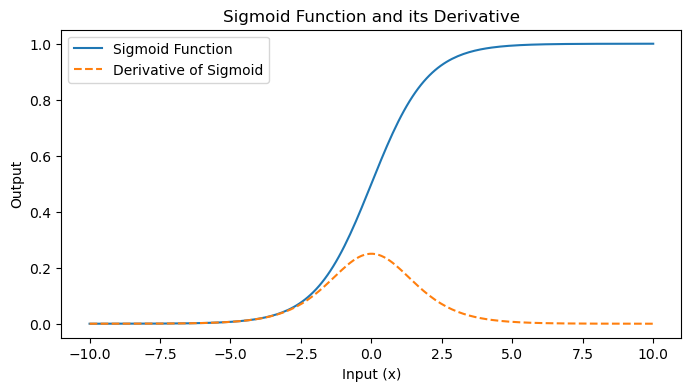

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

# プロット用のデータ
x = np.linspace(-10, 10, 200)
y_sigmoid = sigmoid(x)
y_sigmoid_deriv = sigmoid_derivative(x)

# グラフ描画
plt.figure(figsize=(8, 4))
plt.plot(x, y_sigmoid, label="Sigmoid Function")
plt.plot(x, y_sigmoid_deriv, label="Derivative of Sigmoid", linestyle='--')
plt.title("Sigmoid Function and its Derivative")
plt.xlabel("Input (x)")
plt.ylabel("Output")
plt.legend()
plt.show()

**シグモイド関数の課題**

1.  **勾配消失 (Vanishing Gradient)**
    上のグラフからわかるように、導関数の最大値は $x=0$ のときの $0.25$ です。入力 $x$ の絶対値が大きくなるにつれて、勾配（グラフの傾き）は急激に0に近づきます。

    逆伝播の際、各層の勾配は連鎖律（Chain Rule）によって掛け合わされていきます。深いネットワークでは、この1未満の値（最大でも0.25）が何度も掛け合わされることになります。
    $$
    \frac{\partial L}{\partial w_{ij}^{(1)}} = \dots \times \sigma'(net^{(k)}) \times \dots \times \sigma'(net^{(2)}) \times \dots
    $$
    これにより、入力層に近い層に伝わる頃には勾配がほとんど0になってしまい、重みの更新がほぼ行われなくなります。これが「勾配消失」問題であり、深いネットワークの学習を著しく困難にします。

2.  **出力がゼロ中心でない (Not zero-centered)**
    シグモイド関数の出力は常に $(0, 1)$ の範囲にあり、正の値しか取りません。これにより、後続の層への入力が常に正となり、学習の効率を下げることがあります（ジグザグ現象）。この問題は次のTanh関数で一部解決されます。

### 3.2 双曲線正接関数 (Hyperbolic Tangent, Tanh)

Tanh関数は、シグモイド関数をスケールし、出力を $(-1, 1)$ の範囲にしたものです。出力がゼロ中心になったことで、シグモイド関数よりも学習効率が良いとされています。

**数式:**
$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} = 2 \sigma(2x) - 1
$$

**導関数:**
$$
\tanh'(x) = 1 - \tanh^2(x)
$$

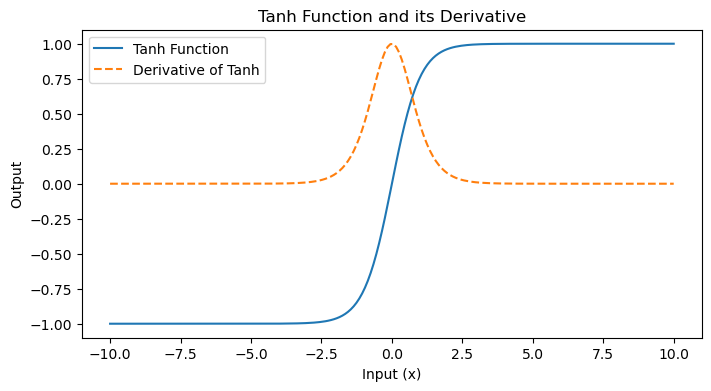

In [6]:
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

# プロット用のデータ
x = np.linspace(-10, 10, 200)
y_tanh = tanh(x)
y_tanh_deriv = tanh_derivative(x)

# グラフ描画
plt.figure(figsize=(8, 4))
plt.plot(x, y_tanh, label="Tanh Function")
plt.plot(x, y_tanh_deriv, label="Derivative of Tanh", linestyle='--')
plt.title("Tanh Function and its Derivative")
plt.xlabel("Input (x)")
plt.ylabel("Output")
plt.legend()
plt.show()

**Tanh関数の課題**

Tanh関数は出力をゼロ中心にすることでシグモイドの問題点を一つ解決しましたが、グラフを見るとわかるように、入力の絶対値が大きい領域で勾配が0に近づくという**勾配消失問題は依然として残っています。**
この根深い問題を解決したのが、次世代の標準となるReLUです。


## 4. ReLUとその派生形

勾配消失問題を劇的に改善し、ディープラーニングの発展を可能にしたのがReLU（正規化線形ユニット）とその仲間たちです。

### 4.1 正規化線形ユニット (Rectified Linear Unit, ReLU)

ReLUは非常にシンプルな関数で、入力が0より大きければそのまま出力し、0以下なら0を出力します。

**数式:**
$$
\text{ReLU}(x) = \max(0, x) =
\begin{cases}
x & \text{if } x > 0 \\
0 & \text{if } x \le 0
\end{cases}
$$

**導関数:**
$$
\text{ReLU}'(x) =
\begin{cases}
1 & \text{if } x > 0 \\
0 & \text{if } x \le 0
\end{cases}
$$
（$x=0$では数学的には微分不可能ですが、実装上は0または1として扱います）

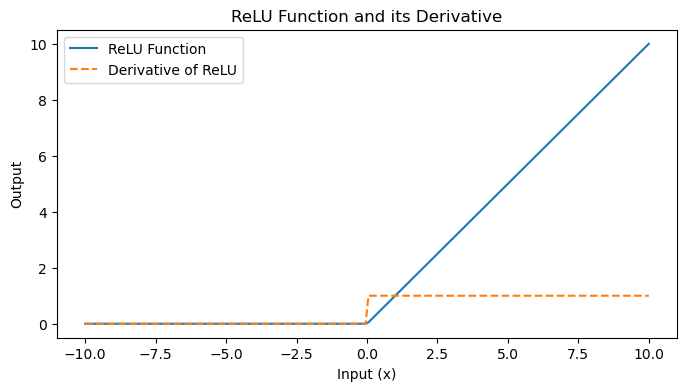

In [7]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# プロット用のデータ
x = np.linspace(-10, 10, 200)
y_relu = relu(x)
y_relu_deriv = relu_derivative(x)

# グラフ描画
plt.figure(figsize=(8, 4))
plt.plot(x, y_relu, label="ReLU Function")
plt.plot(x, y_relu_deriv, label="Derivative of ReLU", linestyle='--')
plt.title("ReLU Function and its Derivative")
plt.xlabel("Input (x)")
plt.ylabel("Output")
plt.legend()
plt.show()

**ReLUの利点**

1.  **勾配消失問題の緩和**: 入力が正の領域では、勾配が常に1です。これにより、層を深くしても勾配が小さくなりにくく、学習が効率的に進みます。
2.  **計算効率**: $\max(0, x)$ という計算は、シグモイドやTanhの指数計算に比べて非常に高速です。
3.  **スパース性**: 入力が負の場合、出力が0になるため、ニューロンの一部だけが活性化する「スパースな表現」を自然に作り出します。これは計算効率や汎化性能に寄与すると考えられています。

**ReLUの課題: Dying ReLU**

ReLUの唯一の欠点は、入力が負の領域に入ると勾配も出力も0になってしまうことです。もし学習中に大きな勾配が来てニューロンの重みが更新され、あらゆる入力に対して出力が負になるようになってしまうと、そのニューロンの勾配は常に0となり、二度と学習によって復活できなくなります。これを「死んだReLU (Dying ReLU)」問題と呼びます。

### 4.2 Leaky ReLU

Leaky ReLUは、Dying ReLU問題を解決するために提案されました。入力が負の場合でも、完全に0にするのではなく、わずかな傾き（リーク）を持たせます。

**数式:**
$$
\text{LeakyReLU}(x) = \max(\alpha x, x) =
\begin{cases}
x & \text{if } x \ge 0 \\
\alpha x & \text{if } x < 0
\end{cases}
$$
ここで $\alpha$ は $0.01$ のような小さな正の定数です。

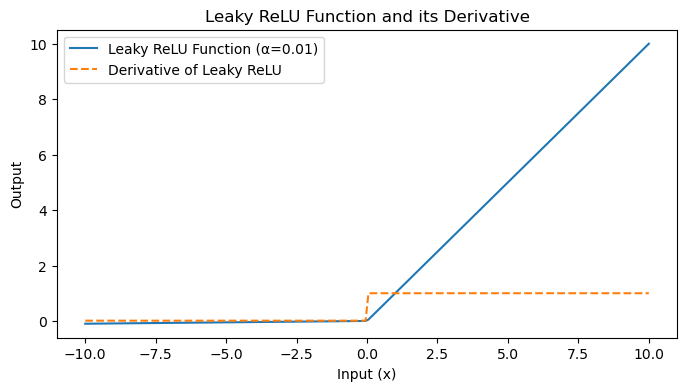

In [8]:
def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

# プロット用のデータ
x = np.linspace(-10, 10, 200)
y_leaky_relu = leaky_relu(x)
y_leaky_relu_deriv = leaky_relu_derivative(x)

# グラフ描画
plt.figure(figsize=(8, 4))
plt.plot(x, y_leaky_relu, label="Leaky ReLU Function (α=0.01)")
plt.plot(x, y_leaky_relu_deriv, label="Derivative of Leaky ReLU", linestyle='--')
plt.title("Leaky ReLU Function and its Derivative")
plt.xlabel("Input (x)")
plt.ylabel("Output")
plt.legend()
plt.show()


### 4.3 指数関数的線形ユニット (Exponential Linear Unit, ELU)

ELUは、Dying ReLU問題に対処しつつ、出力がゼロ中心に近づくように設計された関数です。負の領域が滑らかな曲線になっているのが特徴です。

**数式:**
$$
\text{ELU}(x) =
\begin{cases}
x & \text{if } x \ge 0 \\
\alpha (e^x - 1) & \text{if } x < 0
\end{cases}
$$
通常、$\alpha=1.0$ と設定されます。

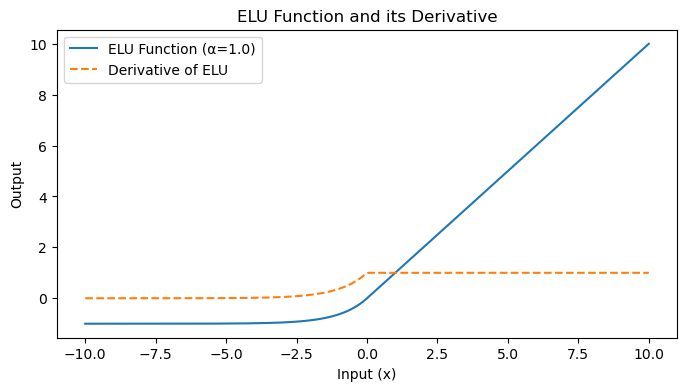

In [9]:
def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def elu_derivative(x, alpha=1.0):
    return np.where(x > 0, 1, alpha * np.exp(x))

# プロット用のデータ
x = np.linspace(-10, 10, 200)
y_elu = elu(x)
y_elu_deriv = elu_derivative(x)

# グラフ描画
plt.figure(figsize=(8, 4))
plt.plot(x, y_elu, label="ELU Function (α=1.0)")
plt.plot(x, y_elu_deriv, label="Derivative of ELU", linestyle='--')
plt.title("ELU Function and its Derivative")
plt.xlabel("Input (x)")
plt.ylabel("Output")
plt.legend()
plt.show()

## 5. より現代的な活性化関数

近年、ReLUの性能をさらに上回ることを目指して、より洗練された活性化関数が提案されています。特にTransformerベースのモデルで広く採用されています。

### 5.1 Swish

Swishは、Googleの研究者たちがNAS（Neural Architecture Search）という自動探索技術を用いて発見した関数です。ReLUと同様の形状を持ちつつ、負の領域でわずかに値が下がる非単調な性質が特徴です。

**数式:**
$$
\text{Swish}(x) = x \cdot \sigma(\beta x) = \frac{x}{1 + e^{-\beta x}}
$$
$\beta$ は学習可能なパラメータですが、通常は1に固定されます。

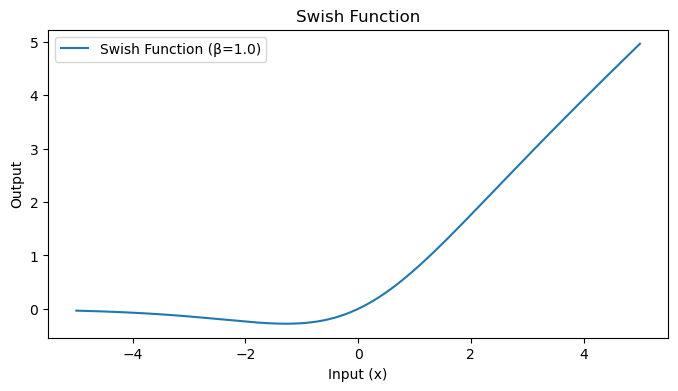

In [10]:
def swish(x, beta=1.0):
    return x * sigmoid(beta * x)

# プロット用のデータ
x = np.linspace(-5, 5, 200)
y_swish = swish(x)

# グラフ描画
plt.figure(figsize=(8, 4))
plt.plot(x, y_swish, label="Swish Function (β=1.0)")
plt.title("Swish Function")
plt.xlabel("Input (x)")
plt.ylabel("Output")
plt.legend()
plt.show()

### 5.2 GELU (Gaussian Error Linear Unit)

GELUは、確率的なアプローチに基づいており、「入力にガウスノイズを乗算した値の期待値」として定義されます。これにより、入力値に応じて確率的にニューロンをドロップアウトするような効果をもたらします。BERTやGPTといった主要なTransformerモデルで標準的に採用されています。

**数式（近似式）:**
$$
\text{GELU}(x) \approx 0.5x \left(1 + \tanh\left[\sqrt{2/\pi}(x + 0.044715x^3)\right]\right)
$$

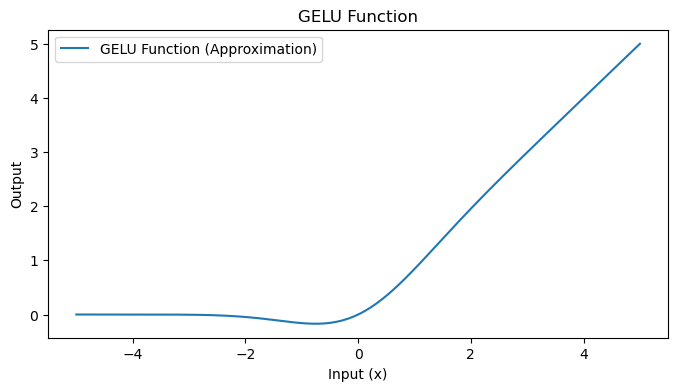

In [11]:
def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

# プロット用のデータ
x = np.linspace(-5, 5, 200)
y_gelu = gelu(x)

# グラフ描画
plt.figure(figsize=(8, 4))
plt.plot(x, y_gelu, label="GELU Function (Approximation)")
plt.title("GELU Function")
plt.xlabel("Input (x)")
plt.ylabel("Output")
plt.legend()
plt.show()

## 6. まとめと実践的なガイドライン

これまで見てきた活性化関数を比較し、どのような場面でどれを使えばよいかの指針をまとめます。

| 活性化関数 | 特徴 | 利点 | 欠点 | 主な用途 |
| :--- | :--- | :--- | :--- | :--- |
| **Sigmoid** | (0, 1)の滑らかなS字曲線 | 出力を確率として解釈可能 | 勾配消失、ゼロ中心でない | 2値分類の出力層、ゲート機構 |
| **Tanh** | (-1, 1)の滑らかなS字曲線 | ゼロ中心である | 勾配消失 | 古典的なRNN、中間層 |
| **ReLU** | シンプルなmax(0, x) | 勾配消失を緩和、高速 | Dying ReLU | **デフォルトの選択肢**、CNN/MLP中間層 |
| **Leaky ReLU** | 負の領域でわずかな傾き | Dying ReLUを解決 | - | ReLUの代替 |
| **ELU** | 負の領域が滑らかな指数曲線 | Dying ReLU解決、ゼロ中心に近づく | 指数計算でやや遅い | ReLU/Leaky ReLUの代替 |
| **Swish/GELU**| 滑らかで非単調な曲線 | 高性能（特に深層モデルで） | 計算コストが高い | Transformerベースのモデル |

**実践的な選択フロー:**
1.  **迷ったらまずReLUを使う。** シンプルで高速、そしてほとんどの場合で非常にうまく機能します。
2.  学習が停滞し、Dying ReLUが疑われる場合（多くのニューロンの出力が0のままになるなど）は、**Leaky ReLU**や**ELU**を試します。
3.  計算リソースに余裕があり、最高の性能を求める場合、特にTransformerのような最新のアーキテクチャでは、**Swish**や**GELU**が良い結果をもたらすことが多いです。
4.  **Sigmoid**は、二値分類問題の最終出力層で確率を得るために、現在でも不可欠です。また、LSTMやGRUのゲート機構でも重要な役割を果たしています。